<h1>Red Wine Quality</h1h>
<h2>Objective</h2>

* Investigate data set.
* Perform Data cleaning and exploratory data analysis.
* Perform statistical inference.
* Apply linear machine learning models to predict the Quality and Alcohol features using the other 11 features.
* Create a dashboard.

<h2>Investigating the dataset</h2>

Dataset downloaded from: https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009?resource=download

<h3>Units of measure</h3>
The dataset had no mention of units of measure. This is a bit troubling as it's not clear if the corresponding features are measured in the same units. But due to lack of information, this study will assume the units are matching for corresponding features.

* Fixed Acidity: g/L
* Volatile Acidity: mg/L or g/L (for higher concentrations).
* Citric Acid: g/L.
* Residual Sugar: g/L or g/dL.
* Chlorides: g/L or mg/L.
* Free Sulfur Dioxide: Parts per million (ppm) or mg/L.
* Total Sulfur Dioxide: ppm or mg/L.
* Density: g/mL or kg/L.
* pH: Unit-less measurement of acidity or alkalinity.
* Sulphates: g/L.
* Alcohol: Usually expressed as a percentage by volume (% vol) or in terms of alcohol by volume (ABV).

Output variable, based on sensory data:
* Quality: Ordinal score between 0 and 10.

<h3>Downloading data</h3>

In [1]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import mannwhitneyu

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.utils import resample


import seaborn as sns

import textblob
from unidecode import unidecode

pd.plotting.register_matplotlib_converters()
%matplotlib inline

<h3>Exploratory data analysis</h3>

In [306]:
def data_download(path: str) -> pd.DataFrame:
    """Download data and capitalize the column names."""
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.capitalize()
    return df


def first_look(df: pd.DataFrame) -> None:
    """Performs initial data set analysis."""
    print(f'Column data types:\n{df.dtypes}\n')
    print(f'Dataset has {df.shape[0]} observations and {df.shape[1]} features')
    print(f'Columns with NULL values: {df.columns[df.isna().any()].tolist()}')
    print(f'Dataset has {df.duplicated().sum()} duplicates')

def distribution_check(df: pd.DataFrame) -> None:
    """Box plot graph for identifying numeric column outliers, normality of distribution."""
    for feature in df.columns:

        fig, axes = plt.subplots(1, 3, figsize=(12, 3))  # Creating subplots

        print(f'{feature.capitalize()}')

        # Outlier check (Box plot)
        df.boxplot(column=feature, ax=axes[0])
        # sns.boxplot(data=df, y=feature, x='Quality', ax=axes[0])
        axes[0].set_title(
            f'{feature.capitalize()} ranges from {df[feature].min()} to {df[feature].max()}')

        # Continues features.
        if df[feature].dtype != 'int64':
            # Distribution check (Histogram).
            sns.histplot(data=df, x=feature, kde=True, bins=20, ax=axes[1])
            axes[1].set_title(f'Distribution of {feature.capitalize()}')

            # Normality check (QQ plot).
            sm.qqplot(df[feature], line='s', ax=axes[2])
            axes[2].set_title(f'Q-Q plot of {feature.capitalize()}')

        # Ordinal features.
        else:
            # Distribution check (Histogram) without KDE.
            sns.histplot(data=df, x=feature, bins=20, ax=axes[1])
            axes[1].set_title(f'Distribution of {feature.capitalize()}')

            # Turining off the 3rd layer as Ordinal features made to have only 2 plots.
            axes[2].axis('off')

        plt.tight_layout()
        plt.show()

In [307]:
"""Statistics"""
alpha = 0.05  # Significance level
confidence_level = 0.95

In [308]:
"""Setting graph parameters"""
sns.set(style='whitegrid')
sns.set_palette('flare')

Data has no empty values. 11 features are float type and 1 (Quality) is an interger.

In [309]:
wine_quality = data_download(r"..\Sprint3\winequality-red.csv")
first_look(wine_quality)

Column data types:
Fixed acidity           float64
Volatile acidity        float64
Citric acid             float64
Residual sugar          float64
Chlorides               float64
Free sulfur dioxide     float64
Total sulfur dioxide    float64
Density                 float64
Ph                      float64
Sulphates               float64
Alcohol                 float64
Quality                   int64
dtype: object

Dataset has 1599 observations and 12 features
Columns with NULL values: []
Dataset has 240 duplicates


<h4>Duplicates</h4>
The dataset has 240 duplicates. 

* It is a small dataset and removing values could lead to loss of variability. 
* Features are physical measurements. Often physical measurements are repeated and identical sensor readings might occur legitimately.

Duplicates will not be removed.

In [310]:
# Data without duplicates
wine_quality[wine_quality.duplicated()]['Quality'].value_counts()

5    104
6    103
7     32
8      1
Name: Quality, dtype: int64

In [311]:
# Data with duplicates
wine_quality['Quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: Quality, dtype: int64

<h4>Anomalies</h4>

* Boxplots allow to check for outliers. Features seem to have outliers / values are concentrated at certain areas. No outliers will be removed as the dataset is imbalanced and it's not clear if the imbalance makes datapoints looks like false outliers.
* Histplot and Q-Q plot shows normality of distribution. Residual sugar, Chlorides, Total sulfur dioxide have non normal distribution. 
* Quality is an ordinal feature and Q-Q plot is not bringing much information, so it is not showed. Quality was expected to range from 0 to 10, but this dataset has only 3 to 8 score range. 

Fixed acidity


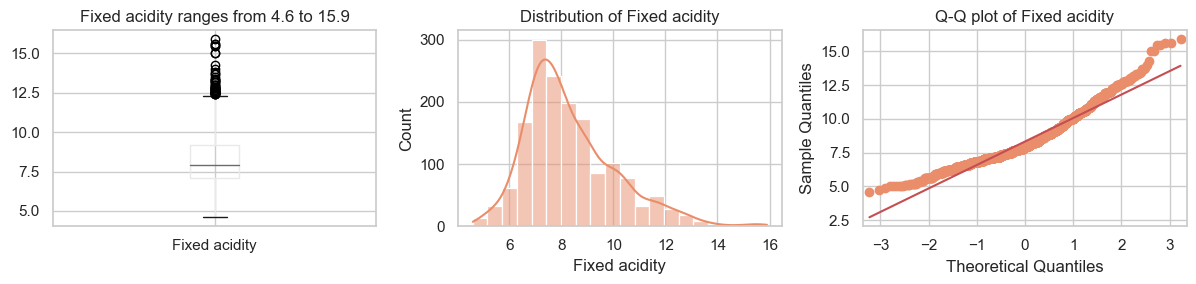

Volatile acidity


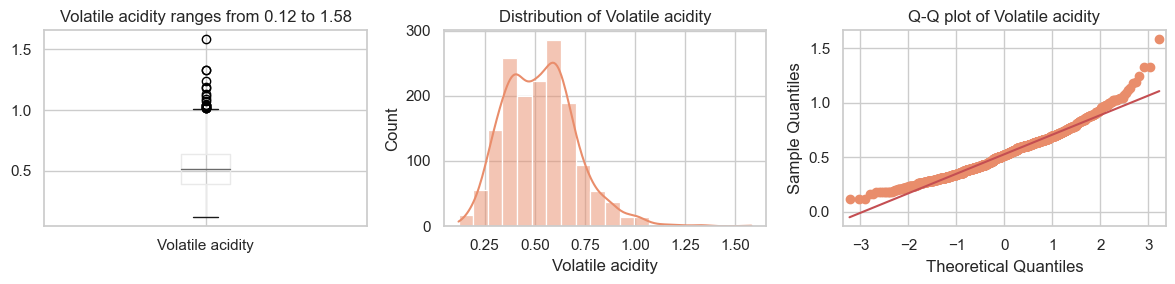

Citric acid


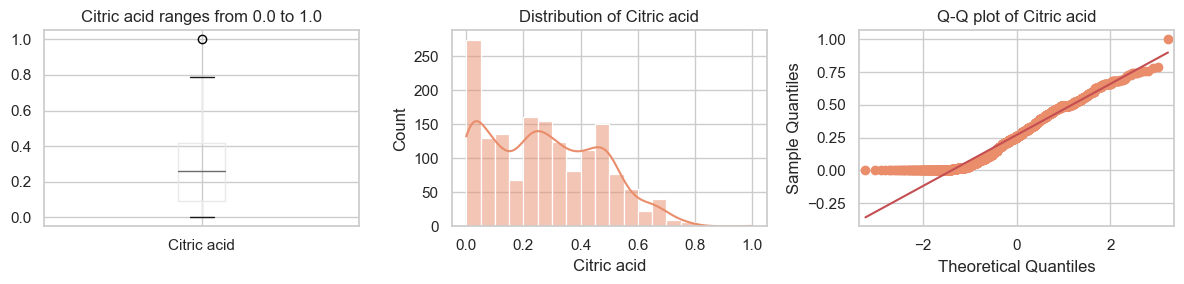

Residual sugar


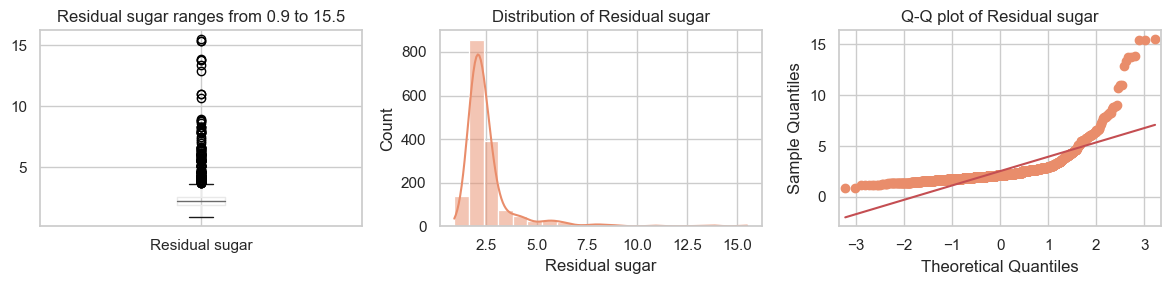

Chlorides


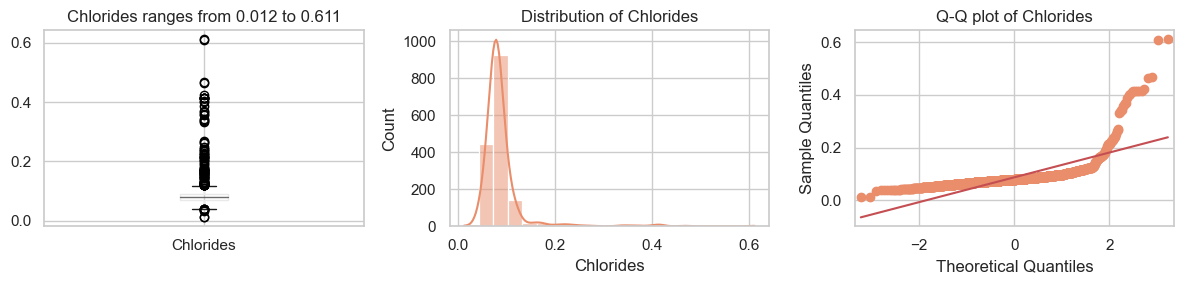

Free sulfur dioxide


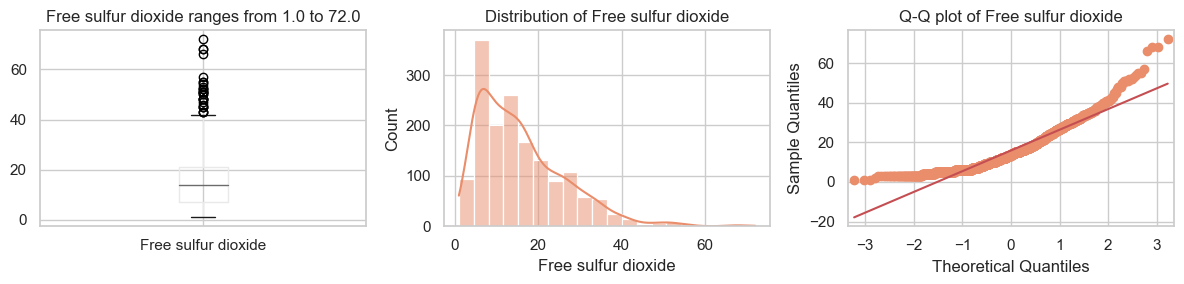

Total sulfur dioxide


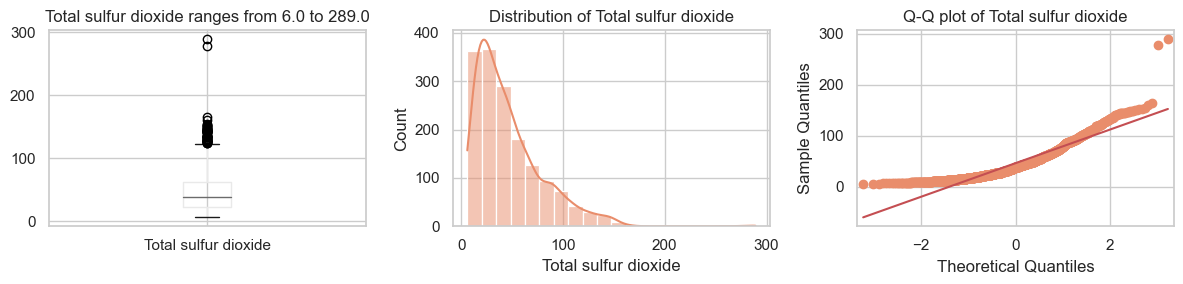

Density


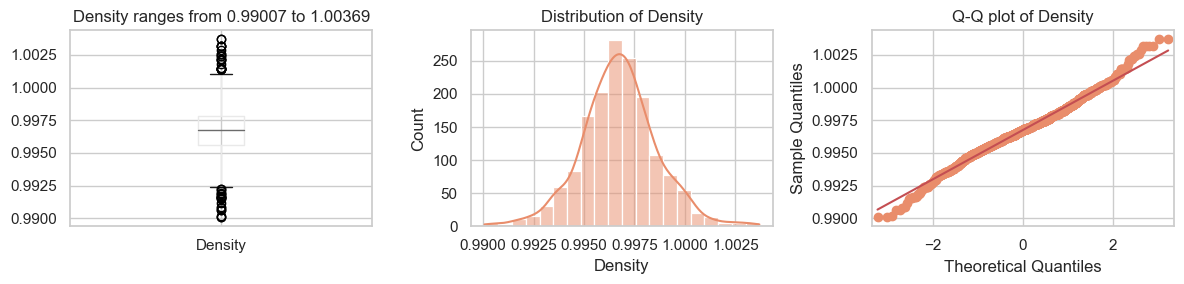

Ph


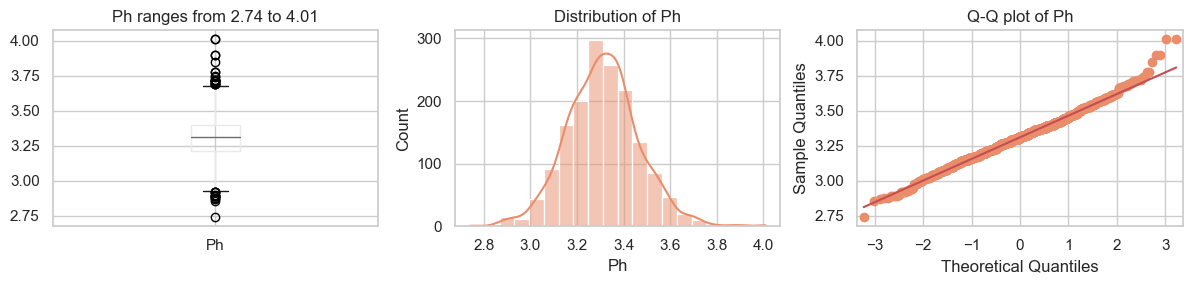

Sulphates


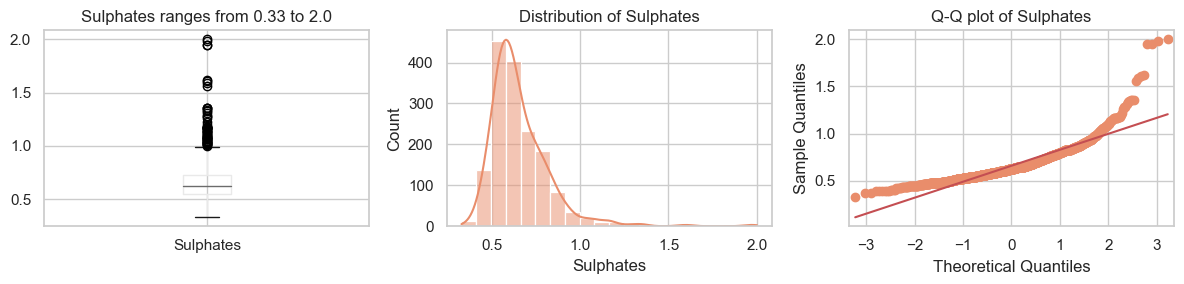

Alcohol


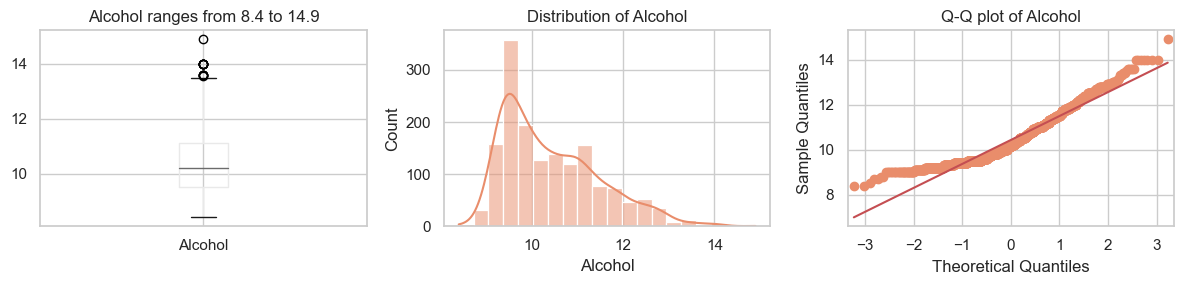

Quality


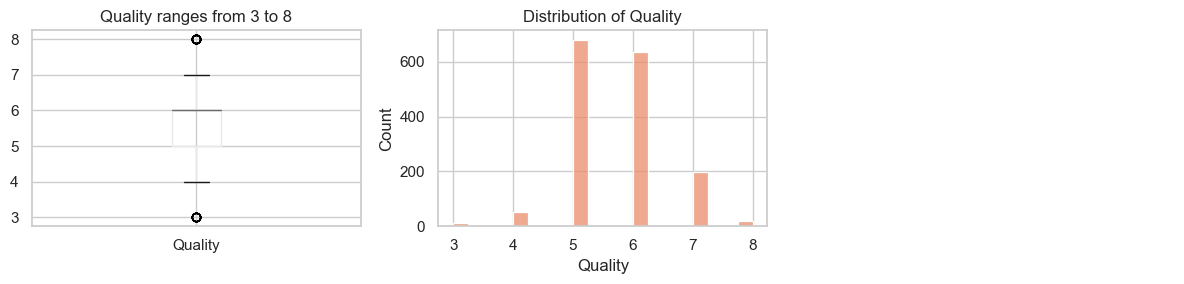

In [312]:
distribution_check(wine_quality)

<h5>Conclussion</h5>
Dataset is imbalanced for Quality. It's not apparent if the outliers are true outliers and no rows will be removed from dataset.


Independence: The residuals (the differences between observed and predicted values) should be independent of each other. In simpler terms, the errors should not be correlated with one another.

Homoscedasticity: The variance of the residuals should remain constant across all levels of the predictors. In other words, the spread of the residuals should be consistent along the range of predicted values.

Normality of Residuals: The residuals should follow a normal distribution. This assumes that the errors or residuals are normally distributed around a mean of zero.

No Multicollinearity: In models with multiple predictors, the predictors should not be highly correlated with each other. High multicollinearity can make it challenging to estimate individual predictors' effects on the outcome.

No Autocorrelation: In time series or sequential data, there should be no correlation between residuals at different time points. Each residual should be independent of the others.

<h3>Feature dependence</h3>
<h4>Correlation</h4>

Pearson's Correlation Coefficient was choosen because 11 features are Continuous and Quality is Ordinal. Pearson's Correlation is fit to measure the linear relationship between a continuous variable and an ordinal discrete variable.

Strong correlation is considered for abs(r) > 0.75. No 2 features have strong positive (both follow the same linear trend) or negative correlation (both follow the opposite linear trend).

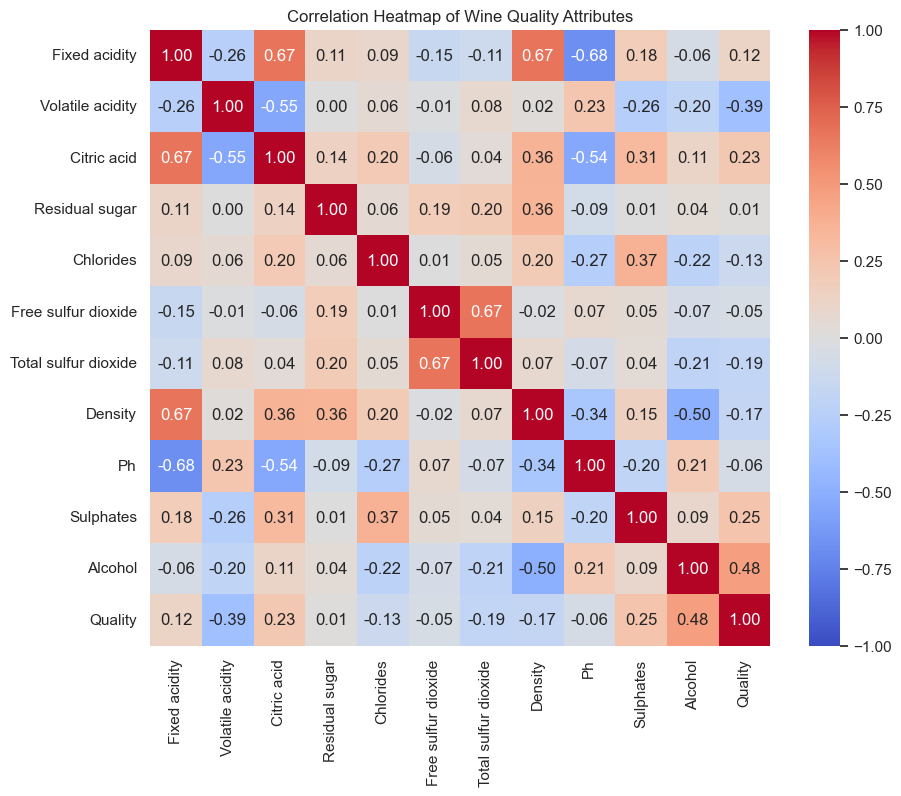

In [313]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(wine_quality.corr(), annot=True,
            cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Wine Quality Attributes')
plt.show()

<h5>Correlation in Categorical and Continues values</h5>
Quality is an Ordinal feature. Spearman's rank correlation coefficient calculates the correlation based on the ranks of the values rather than the actual values themselves.

Null hypothesis: Quality and Alcohol do not have a correlation relationship. <br>
Alternative Hypotheses: Quality and Alcohol do have a correlation relationship.<br>

In [314]:
correlation, p_value = stats.spearmanr(
    wine_quality['Quality'], wine_quality['Alcohol'])

if p_value < alpha:
    print(
        f"p-value = {p_value:.4f}. Reject null hypothesis. Spearman's correlation:  {correlation:.4f}")
else:
    print(
        f"p-value = {p_value:.4f}. Fail to reject null hypothesis. Spearman's correlation:  {correlation:.4f}")

p-value = 0.0000. Reject null hypothesis. Spearman's correlation:  0.4785


<h5>Conclusion</h5>
No features are correlated linearly. Spearman's correlation coefficient showed that Quality is dependent on Alcohol.

<h4>2. No Multicollinearity</h4>
Multicollinearity occurs when two or more features in a model are highly correlated with each other, leading to redundant information or interference in the linear models. 


Variance Inflation Factor can predict Multicollinearity:

    VIF = 1/ (1-R^2)

R^2 - coefficient of determination

* VIF = 1, no correlation between the independent variable and the other variables
* VIF above 5 or 10 indicates high Multicollinearity between this independent variable and the others

Variance Inflation Factor (VIF) is specifically designed to detect Multicollinearity. VIF quantifies the severity of Multicollinearity in an ordinary least squares regression analysis. It's calculated by assessing how much the variance of a regression coefficient is inflated due to Multicollinearity in the model.

In [315]:
def vif(df):
    """Calculating Variance Inflation Factor (VIF)."""
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(
        df.values, i) for i in range(df.shape[1])]

    return (vif)

<h5>Testing Outlier removal for Multicollinearity reduction</h5>
Testing removing Quality outliers (3, 8) from dataset. 

Here's an example without row removal on acidity related features. VIF for 3 features are > 5.

In [316]:
vif(wine_quality[['Fixed acidity', 'Volatile acidity', 'Citric acid']])

,variables,VIF
0,Fixed acidity,24.165925
1,Volatile acidity,10.157333
2,Citric acid,7.447576


Removing rows for Quality outliers does not bring down acidity related feature Multicollinearity. In fact, it slightly increases it.

In [317]:
wine_quality_reduced = wine_quality[~wine_quality['Quality'].isin([3, 4, 8])]
vif(wine_quality_reduced[['Fixed acidity', 'Volatile acidity', 'Citric acid']])

,variables,VIF
0,Fixed acidity,25.077795
1,Volatile acidity,10.549557
2,Citric acid,7.622118


<h5>Conclusion</h5>
Multicollinearity is not reduced by removing outliers from features.

<h5>Multicollinearity reduction by feature addition</h5>
Only Residual Sugar has VIF > 5. The other features depend on each other.

* Fixed acidity and Volatile acidity looks Multicollinear. Their ranges are not the same, Fixed acidity is 10 times the scale of Volatile acidity. Scales will be aligned.
* Free sulfur dioxide and Total sulfur dioxide. Their scales are 2 different.
* Density, Ph and Alcohol. Their physical units don't match and their ranges are different. However, this does not hinder modeling, a combined value for Density and Ph will be created.

In [318]:
vif(wine_quality.iloc[:, :-1])

,variables,VIF
0,Fixed acidity,74.452265
1,Volatile acidity,17.060026
2,Citric acid,9.183495
3,Residual sugar,4.662992
4,Chlorides,6.554877
5,Free sulfur dioxide,6.442682
6,Total sulfur dioxide,6.519699
7,Density,1479.287209
8,Ph,1070.967685
9,Sulphates,21.590621


Grouping features based on their VIF values. I.e. grouping Acidity, dioxide related features.

In [319]:
currated_wine = (duckdb.query("""
                              SELECT "Citric acid", "Residual sugar", Chlorides, 
                              Sulphates, Alcohol, Density, Ph, Quality,
                              "Fixed acidity" / 10 + "Volatile acidity" AS Acidity,
                              "Total sulfur dioxide" + "Free sulfur dioxide" * 2 AS Dioxides,
                              Density + Ph AS Density_Ph,
                              "Fixed acidity" / 10 + "Volatile acidity"+ Sulphates + Density + Ph + Alcohol 
                              AS Acidity_Sulphates_Density_Ph_Alcohol
                              FROM wine_quality
                            """).to_df())

Grouping features still leaves high VIF values.

In [320]:
vif(currated_wine[['Acidity', 'Citric acid',
    'Residual sugar', 'Chlorides', 'Dioxides', 'Density_Ph']])

,variables,VIF
0,Acidity,36.770566
1,Citric acid,3.110070
2,Residual sugar,4.601674
3,Chlorides,4.689574
4,Dioxides,3.700049
5,Density_Ph,37.708479


Grouping even more (Acidity, Sulphates, Density, Ph, Alcohol) is still not satisfactory wit VIF > 5. But it's the best of bad situation.

In [321]:
vif(currated_wine.loc[:, ~currated_wine.columns.isin(
    ['Density_Ph', 'Acidity', 'Sulphates', 'Alcohol', 'Density', 'Ph', 'Quality'])])

,variables,VIF
0,Citric acid,3.158438
1,Residual sugar,4.580003
2,Chlorides,4.457066
3,Dioxides,3.573209
4,Acidity_Sulphates_Density_Ph_Alcohol,8.823063


<h5>Conclussion</h5>
Dataset has features Acidity, Sulphates, Density, Ph, Alcohol that are dependent on each other.

<h1>Hypothesies</h1>

<h2>Quality changes and other features</h2>

Null hypothesis: Quality 5 and 6 does not differ in means of each 11 features. <br>
Alternative Hypotheses: Quality 5 and 6 differ in means of each 11 features.<br>

In [322]:
def significance_t_test(df: pd.DataFrame, feature: str, change_feature: str, 
                        min_change_value: float, max_change_value: float) -> None:
    """Perform a t-test (sample size is small or when 
    the population standard deviation is unknown) and follows a normal distribution."""
    t_stat, p_value = stats.ttest_ind(df[df[change_feature] == min_change_value][feature],
                                      df[df[change_feature] == max_change_value][feature], equal_var=False)

    if p_value < alpha:
        print(
            f'p-value = {p_value:.4f} between {feature} and {change_feature}. Reject null hypothesis')
    else:
        print(
            f'p-value = {p_value:.4f} between {feature} and {change_feature}. Fail to reject null hypothesis')


def category_Mann_Whitney_U_test(df: pd.DataFrame, feature: str, change_feature: str, 
                                 min_change_value: float, max_change_value: float) -> None:
    """Category Mann-Whitney U test."""

    statistic, p_value = mannwhitneyu(df[df[change_feature] == min_change_value][feature],
                                      df[df[change_feature] == max_change_value][feature])

    if p_value < alpha:
        print(
            f'p-value = {p_value:.4f} between {feature} and {change_feature}. Reject null hypothesis')
    else:
        print(
            f'p-value = {p_value:.4f} between {feature} and {change_feature}. Fail to reject null hypothesis')


def confidence_intervals(data) -> None:
    """Calculate Confidence Intervals"""

    sample_mean = np.mean(data)
    sample_std = np.std(data, ddof=1)  # ddof=1 for sample standard deviation

    critical_value = stats.norm.ppf((1 + confidence_level) / 2)

    standard_error = sample_std / np.sqrt(len(data))
    margin_of_error = critical_value * standard_error

    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error

    print(f"Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")

In [323]:
non_normal_features = ['Residual sugar', 'Chlorides', 'Total sulfur dioxide']
normal_features = [
    col for col in wine_quality.columns if col not in non_normal_features]

In [324]:
for i in normal_features:
    significance_t_test(wine_quality, i, 'Quality', 5, 6)

p-value = 0.0534 between Fixed acidity and Quality. Fail to reject null hypothesis
p-value = 0.0000 between Volatile acidity and Quality. Reject null hypothesis
p-value = 0.0037 between Citric acid and Quality. Reject null hypothesis
p-value = 0.0272 between Free sulfur dioxide and Quality. Reject null hypothesis
p-value = 0.0000 between Density and Quality. Reject null hypothesis
p-value = 0.1183 between Ph and Quality. Fail to reject null hypothesis
p-value = 0.0000 between Sulphates and Quality. Reject null hypothesis
p-value = 0.0000 between Alcohol and Quality. Reject null hypothesis
p-value = 0.0000 between Quality and Quality. Reject null hypothesis


c:\Users\Gintare\anaconda3\envs\dswh_env\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [325]:
for i in non_normal_features:
    category_Mann_Whitney_U_test(wine_quality, i, 'Quality', 5, 6)

p-value = 0.7123 between Residual sugar and Quality. Fail to reject null hypothesis
p-value = 0.0000 between Chlorides and Quality. Reject null hypothesis
p-value = 0.0000 between Total sulfur dioxide and Quality. Reject null hypothesis


Null hypothesis: Quality 6 and 7 does not differ in means of each 11 features. <br>
Alternative Hypotheses: Quality 6 and 7 differ in means of each 11 features.<br>

In [326]:
for i in normal_features:
    significance_t_test(wine_quality, i, 'Quality', 6, 7)

p-value = 0.0010 between Fixed acidity and Quality. Reject null hypothesis
p-value = 0.0000 between Volatile acidity and Quality. Reject null hypothesis
p-value = 0.0000 between Citric acid and Quality. Reject null hypothesis
p-value = 0.0434 between Free sulfur dioxide and Quality. Reject null hypothesis
p-value = 0.0035 between Density and Quality. Reject null hypothesis
p-value = 0.0266 between Ph and Quality. Reject null hypothesis
p-value = 0.0000 between Sulphates and Quality. Reject null hypothesis
p-value = 0.0000 between Alcohol and Quality. Reject null hypothesis
p-value = 0.0000 between Quality and Quality. Reject null hypothesis


In [327]:
for i in non_normal_features:
    category_Mann_Whitney_U_test(wine_quality, i, 'Quality', 6, 7)

p-value = 0.0095 between Residual sugar and Quality. Reject null hypothesis
p-value = 0.0003 between Chlorides and Quality. Reject null hypothesis
p-value = 0.0000 between Total sulfur dioxide and Quality. Reject null hypothesis


Most features exibit a significan change when Quality changes 5 -> 6 and 6 -> 7. Except for Quality 5 -> 6 for feature Fixed acidity and Residual sugar.

<h4>Sulphates and Ph</h4>
Sulphates influences Ph as the confidence interval for Ph don't overlap when changing Sulphates values.

In [328]:
confidence_intervals(wine_quality[wine_quality['Sulphates'] < 1]['Ph'])

Confidence Interval: [3.31, 3.33]


In [329]:
confidence_intervals(wine_quality[wine_quality['Sulphates'] >= 1]['Ph'])

Confidence Interval: [3.09, 3.16]


<h3>Fixed Acidity and Volatile Acidity</h3>
Fixed Acidity and Volatile Acidity are also related as the Confidence Intervals don't overlap for different values. This can't be seen from gragh or correlation matrix alone. Most likely the relation is not linear.

In [330]:
confidence_intervals(wine_quality[wine_quality['Fixed acidity']
                     < wine_quality['Fixed acidity'].mean()]['Volatile acidity'])

Confidence Interval: [0.55, 0.58]


In [331]:
confidence_intervals(wine_quality[wine_quality['Fixed acidity']
                     >= wine_quality['Fixed acidity'].mean()]['Volatile acidity'])

Confidence Interval: [0.46, 0.49]


As expected, changing the features in places don't produce different results. Having it been the oter way around, it would have been a chllange to explain.

In [332]:
confidence_intervals(wine_quality[wine_quality['Volatile acidity']
                     < wine_quality['Volatile acidity'].mean()]['Fixed acidity'])

Confidence Interval: [8.61, 8.87]


In [333]:
confidence_intervals(wine_quality[wine_quality['Volatile acidity']
                     >= wine_quality['Volatile acidity'].mean()]['Fixed acidity'])

Confidence Interval: [7.78, 7.99]


<h5>Conclussion</h5>
Features in this dataset are overall dependent on eachother.

<h1>Models</h1>
All models will be trained with 20% of the data and validated on the rest 80%.

<h2>Quality</h2>

<h3>Imbalanced Quality</h3>
The calculation below shows row count for various Quality values. This illustrates that Wine quality dataset is imbalanced - there's few instances for all except Quality 5 and 6. This dataset could best suite Classification models that:

* Distinguish between Quality = 5 or the rests
* Good / Bad Wine (Quality > 6.5)

The objective of this analysis is to build linear models. These are the possible solutions:
* Remove rows with Quality 3, 4, 8 (low instances)
* Resampling Techniques: Oversampling the minority class or under-sampling the majority class to balance the dataset.

In an ideal situation - the mean of the features content could be compared for various Qualities. But due to imbalance this is not possible.

In [334]:
wine_quality['Quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: Quality, dtype: int64

<h3>Without feature engineering</h3>
<h4>Training model</h4>
Information Criterion, R^2 (Coefficient of determination) and Condition number are used for model competition. The lower the Information Criterion and Condition number - the better. Larger R^2 indicates a better fit between the model and the observed data.

* Training Model on all 11 features show R^2 = 0.348. 
* Condition number assess the numerical stability of a matrix. It is larger than 30 (1.12e+05), which show that model is suffering from Multicollinearity.
* Akaike Information Criterion (AIC) penalizes the model for the number of parameters included. AIC = 2557.
* Bayesian Information Criterion (BIC) is similar to AIC, but imposes a harsher penalty for model complexity. BIC = 2619.

In [335]:
X = wine_quality.drop(columns=['Quality'])
y = wine_quality['Quality']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

x_train = sm.add_constant(x_train)

model = sm.OLS(y_train, x_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Quality   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     61.48
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          1.48e-109
Time:                        20:30:24   Log-Likelihood:                -1266.4
No. Observations:                1279   AIC:                             2557.
Df Residuals:                    1267   BIC:                             2619.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   14.3551 

<h4>Evaluating model</h4>
Target variable 'Quality' is a quantitative measure, and model puts out float values as predictions from regression model. For this, the predicted values are rounded to the nearest integer to match the nature of the 'Quality' variable.

In [336]:
def predictions(x_test) -> pd.Series:
    """Get predicted values for a linear model."""
    # Add a constant to the test features, same as per model creation
    x_test = sm.add_constant(x_test)

    # Make predictions on the test set
    y_pred = result.predict(x_test)
    y_pred_rounded = y_pred.round().astype(int)

    return y_pred, y_pred_rounded


def evaluation(y_pred_rounded, y_test) -> None:
    """Evaluating the model using metrics"""
    r_squared = r2_score(y_test, y_pred_rounded)
    mae = mean_absolute_error(y_test, y_pred_rounded)
    mse = mean_squared_error(y_test, y_pred_rounded)

    print(f"R-squared Validation: {r_squared:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")


y_pred, y_pred_rounded = predictions(x_test)
evaluation(y_pred_rounded, y_test)

R-squared Validation: 0.3018
Mean Absolute Error (MAE): 0.4375
Mean Squared Error (MSE): 0.4562


R^2 decrease from 0.348 to 0.3018 after model testing. Model is overfitted.

<h4>Visualizing the fitted model</h4>
Values were rounded, because OLD method changes the Ordinal Quality to Continues predicted value. The best predictions were Quality 5 and 6 (the biggest row count groups).

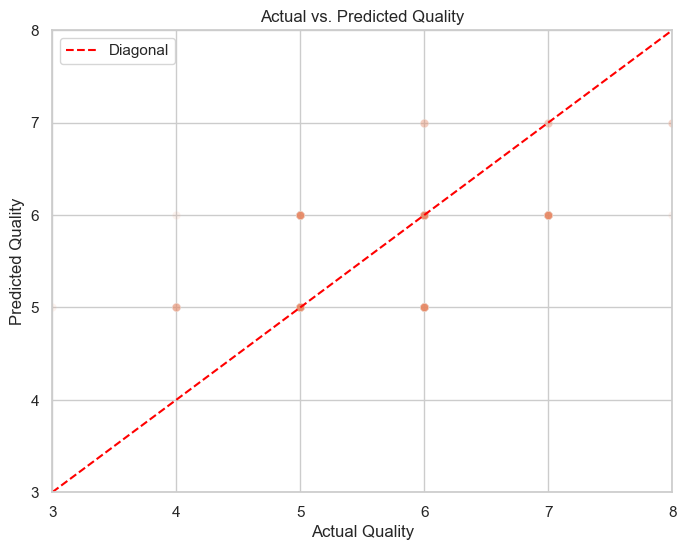

In [337]:
def visualization_fitted_model(y_test, y_pred_rounded, feature) -> None:
    """Visualization for Linear fitted model, for Actual vs predicted values"""
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred_rounded, alpha=0.1)

    # Adding the line f(x) = x
    mean = wine_quality[feature].mean().round()
    plt.axline((mean, mean), slope=1, color='red',
               linestyle='--', label='Diagonal')

    plt.xlabel(f'Actual {feature}')
    plt.ylabel(f'Predicted {feature}')
    plt.title(f'Actual vs. Predicted {feature}')
    plt.legend(loc='upper left')
    min = wine_quality[feature].min()
    max = wine_quality[feature].max()
    plt.xlim(min, max)
    plt.ylim(min, max)

    plt.show()


visualization_fitted_model(y_test, y_pred_rounded, 'Quality')

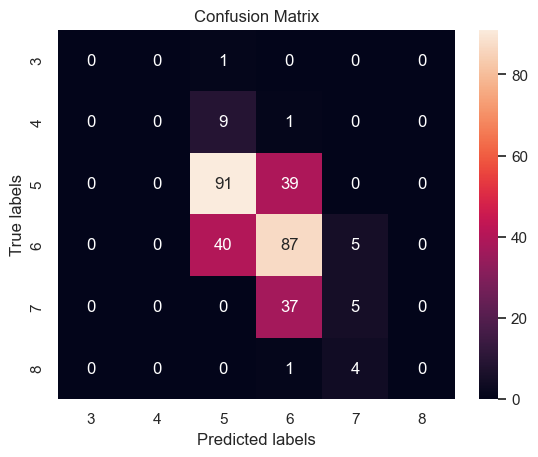

In [338]:
def confusion_matrix_visual(y_test, y_pred_rounded, new_labels: list) -> None:
    """Visualization for Confusion matrix on ordinal values"""
    conf_matrix = confusion_matrix(y_test, y_pred_rounded)

    new_labels = new_labels

    sns.heatmap(conf_matrix, annot=True, fmt='d',
                xticklabels=new_labels, yticklabels=new_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


confusion_matrix_visual(y_test, y_pred_rounded, ['3', '4', '5', '6', '7', '8'])

<h4>Residuals</h4>

Linear regression model assumes the errors are independent and normally distributed.

This plot has high density far away from and close to the origin (Red line). Also, when we project the residuals on the y-axis, we can see the distribution curve is not normal.

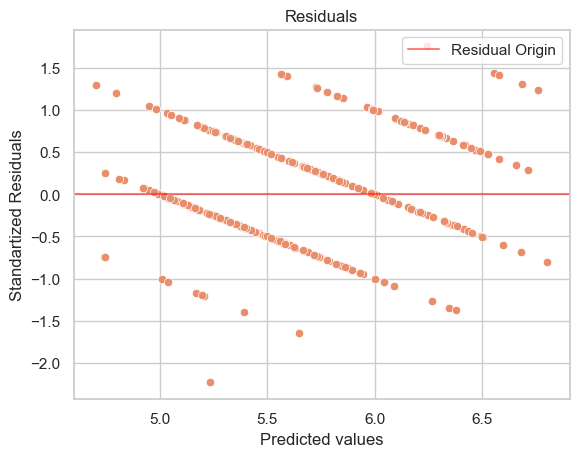

In [339]:
def residual_plot(y_test, y_pred) -> None:
    """Visualization for Residual Values"""
    # Align indices of y_test and y_pred before calculating residuals
    y_test_aligned = y_test.reset_index(drop=True)
    y_pred_aligned = pd.Series(
        y_pred, index=y_test.index).reset_index(drop=True)

    residuals = y_test_aligned - y_pred_aligned

    # Create a DataFrame combining fitted values and residuals
    residual_df = pd.DataFrame(
        {'Fitted Values': y_pred_aligned, 'Residuals': residuals})

    # Residual plot
    sns.scatterplot(x='Fitted Values', y='Residuals', data=residual_df)
    plt.axhline(y=0, color='red', alpha=0.5, label='Residual Origin')
    plt.xlabel('Predicted values')
    plt.ylabel('Standartized Residuals')
    plt.title('Residuals')
    plt.legend(loc='upper right')

    plt.show()


residual_plot(y_test, y_pred)

<h4>Conclusion</h4>
Linear model for Quality using 11 features is suffering from:

* Multicollinearity
* Over-fitted (as seen in R^2 decreasing from 0.348 to 0.3018)
* Best predicted values are Quality for 5 and 6 (biggest row count)
* Residual plot shows that predicted values are not normal and standard deviation is Residuals is up to 2.5.

<h3>Removing Multicollinear features</h3>
Building a model only on low VIF values features: Citric acid, Residual sugar, Chlorides, Dioxides

* Reduced Multicollinearity: Conditional number decreases from 1.5e+5 to 1.93e+3. 
* Reduced model fit:  AIC and BIC increases to 2954 and 2979 respectively. R^2 decreased from 0.348 to 0.101

In [340]:
vif(currated_wine[['Citric acid', 'Residual sugar',
    'Chlorides', 'Dioxides', 'Quality']])

,variables,VIF
0,Citric acid,3.284573
1,Residual sugar,4.461223
2,Chlorides,4.217882
3,Dioxides,3.466441
4,Quality,7.927496


In [341]:
X = currated_wine[['Citric acid', 'Residual sugar', 'Chlorides', 'Dioxides']]
y = currated_wine['Quality']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

x_train = sm.add_constant(x_train)

model = sm.OLS(y_train, x_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Quality   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     35.81
Date:                Tue, 02 Jan 2024   Prob (F-statistic):           2.17e-28
Time:                        20:30:26   Log-Likelihood:                -1471.8
No. Observations:                1279   AIC:                             2954.
Df Residuals:                    1274   BIC:                             2979.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.7818      0.065     88.

Looking at R^2 after validation it is clear that model is also overfitter as R^2 changed values dramatically to -0.0951.

In [342]:
y_pred, y_pred_rounded = predictions(x_test)
evaluation(y_pred_rounded, y_test)

R-squared Validation: -0.0951
Mean Absolute Error (MAE): 0.5781
Mean Squared Error (MSE): 0.7156


<h4>Conclussion</h4>

Removing Multicollinear features  and building a model only on low VIF values features (Citric acid, Residual sugar, Chlorides, Dioxides) did not improve model performance. It actually made it worse.

<h3>Resampling</h3>
Low row count for Quality 3, 4 and 8 could be influencing the model. Resampling will be tested for improving model performance.

Resampling will be done to Quality, to match the maximum row count of largest category (Quality = 5) with all other categories matching at 681 row count.

In [343]:
def resampling(df, feature) -> pd.DataFrame:
    """Resampling data for Ordinal Feature, to match the maximum row count."""
    target_count = df[feature].value_counts().max()
    max_index = df[feature].value_counts().idxmax()
    resampled_wine = df[(df[feature] == max_index)]
    resampled = pd.DataFrame()

    for i in df[feature].unique():
        if i != max_index:
            resampled = resample(
                df[df[feature] == i], replace=True, n_samples=target_count, random_state=42)
            resampled_wine = pd.concat([resampled_wine, resampled], axis=0)
    return resampled_wine


resampled_wine = resampling(wine_quality, 'Quality')
print(resampled_wine['Quality'].value_counts())

5    681
6    681
7    681
4    681
8    681
3    681
Name: Quality, dtype: int64


* R^2 looks promising in comparison to the default model: increase from 0.348 to 0.692.
* AIC and BIC also increased 3.5 times (the complexity of the model increased).
* Conditional Number decreased from 1.12e+5 to 8.30e+04

Resampling looks promising in boiling a better model, further investigations will be made. 

In [344]:
X = resampled_wine.drop(columns=['Quality'])
y = resampled_wine['Quality']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

x_train = sm.add_constant(x_train)

model = sm.OLS(y_train, x_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Quality   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     664.3
Date:                Tue, 02 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:30:26   Log-Likelihood:                -4483.2
No. Observations:                3268   AIC:                             8990.
Df Residuals:                    3256   BIC:                             9064.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.4507 

* R^2 decreased by 0.082 points after evaluation and R^2 still holds above 0.6. 
* Mean Absolute Error with Mean Squared Error increased double in size. This indicates that resampling introduced characteristics that are more challenging for the model to learn.

In [345]:
y_pred, y_pred_rounded = predictions(x_test)
evaluation(y_pred_rounded, y_test)

R-squared Validation: 0.6610
Mean Absolute Error (MAE): 0.6944
Mean Squared Error (MSE): 0.9364


Additional complexity (that is too hard to learn for linear model) is illiustrated by Redicted and Actual Quality values 

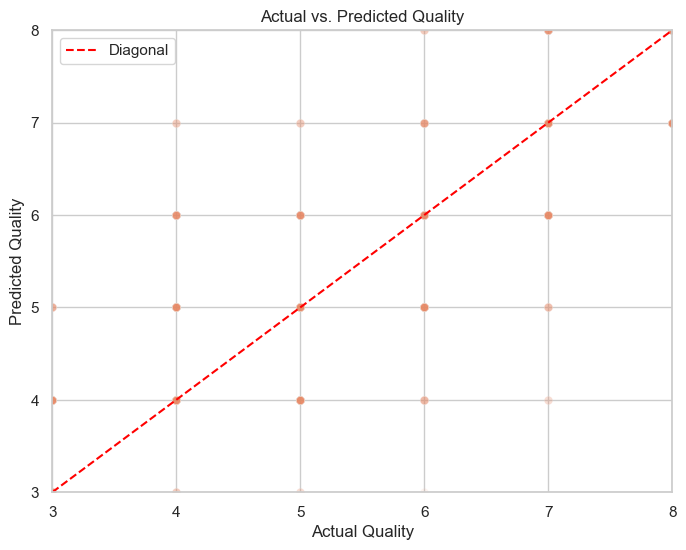

In [346]:
visualization_fitted_model(y_test, y_pred_rounded, 'Quality')

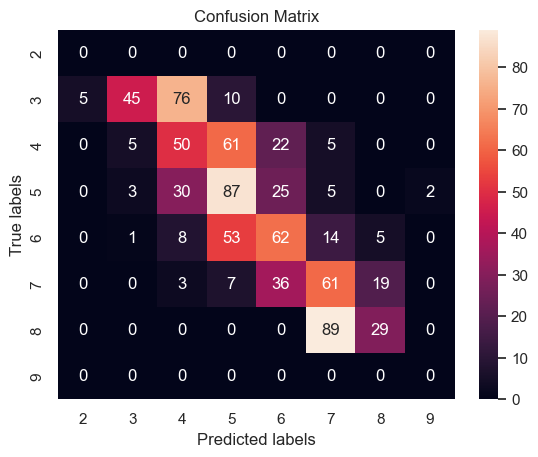

In [347]:
confusion_matrix_visual(y_test, y_pred_rounded, ['2', '3', '4', '5', '6', '7', '8', '9'])

Residual plot also shows large variance.

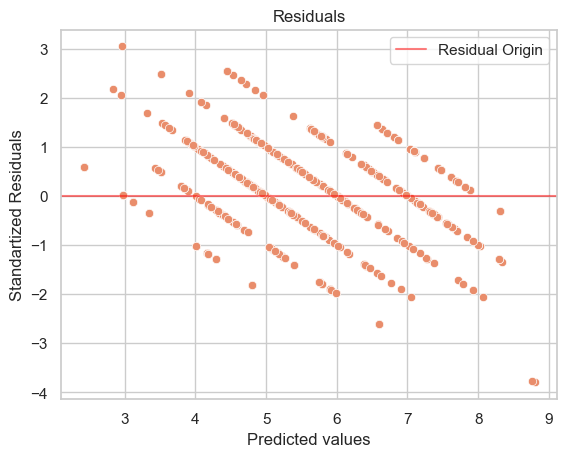

In [348]:
residual_plot(y_test , y_pred)

<h4>Conclusion</h4>

Resampling low count Quality did not improve model performance.

<h3>Dropping outliers</h3>
Removing Quality 3 and 8 (with lowest row count) might help save the model from poor performance.

* R^2 is lower than default value by 0.02.
* AIC and BIC are also smaller by ~200 points
This shows decreased model performance, but also decreased complexity.

In [349]:
X = wine_quality[~wine_quality['Quality'].isin([3, 8])].drop(columns=[
    'Quality'])  # Features
y = wine_quality[~wine_quality['Quality'].isin(
    [3, 8])]['Quality']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

x_train = sm.add_constant(x_train)

model = sm.OLS(y_train, x_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Quality   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     55.11
Date:                Tue, 02 Jan 2024   Prob (F-statistic):           2.86e-99
Time:                        20:30:27   Log-Likelihood:                -1151.4
No. Observations:                1256   AIC:                             2327.
Df Residuals:                    1244   BIC:                             2388.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    9.1822 

* R^2 after evaluation decrease by almost 2 times. This model is over-fitted.
* MEA and MSE stayed roughly the same.

In [350]:
y_pred, y_pred_rounded = predictions(x_test)
evaluation(y_pred_rounded, y_test)

R-squared Validation: 0.1962
Mean Absolute Error (MAE): 0.4508
Mean Squared Error (MSE): 0.4762


<h4>Conclusion</h4>

Dropping Quality Outliers (3, 8) made the linear model over-fitted, with similar values for the mean errors, compared to the default model.

<h3>Quality Model Conclusion</h3>
Dataset is suffering from Multicollinearity and Imbalanced. To combat these issues, Multicollinearity columns and Outliers were removed. Imbalance was combatted with Resampling. However, none of these techniques were successful as Standard errors in Linear Model (MAE, MSE) and Complexity (AIC, BIC) increased.

<h2>Alcohol</h2>

<h3>Without feature engineering</h3>
<h4>Training model</h4>
Information Criterion, R^2 (Coefficient of determination) and Condition number are used for model competition. The lower the Information Criterion and Condition number - the better. Larger R^2 indicates a better fit between the model and the observed data.

* Training Model on all 11 features show R^2 = 0.682. 
* Condition number is larger than 30 (7.81e+4), which show that model is suffering from multicollinearity and might lead to unreliable coefficient estimates.
* AIC = 2320 and BIC = 2382 slightly lower than Quality Models.

In [351]:
X = wine_quality.drop(columns='Alcohol')
y = wine_quality['Alcohol']

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

x_train = sm.add_constant(x_train)

model = sm.OLS(y_train, x_train)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                Alcohol   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     246.6
Date:                Tue, 02 Jan 2024   Prob (F-statistic):          1.85e-305
Time:                        20:30:27   Log-Likelihood:                -1148.1
No. Observations:                1279   AIC:                             2320.
Df Residuals:                    1267   BIC:                             2382.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  549.9910 

R^2 is larger after evaluation by 0.04 points. This shows that model is under-fitted.

In [352]:
y_pred, y_pred_rounded = predictions(x_test)
evaluation(y_pred, y_test)

R-squared Validation: 0.7228
Mean Absolute Error (MAE): 0.4514
Mean Squared Error (MSE): 0.3451


Predicted values of the model don't lie exactly at the diagonal and are mostly at Alcohol = 10.

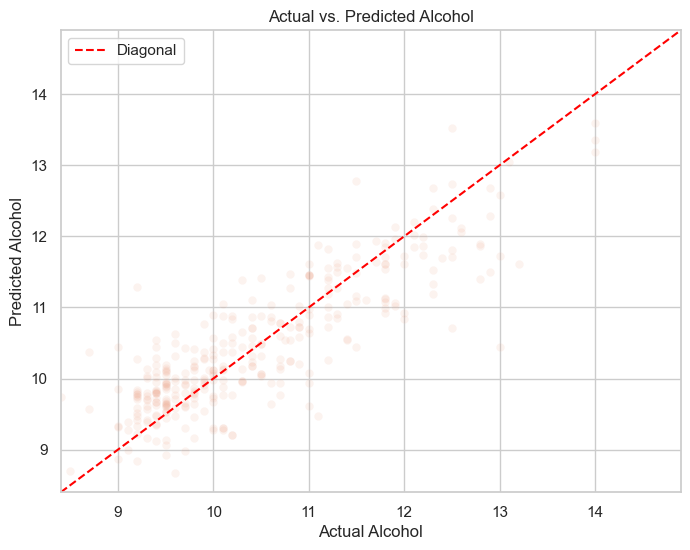

In [353]:
visualization_fitted_model(y_test, y_pred, 'Alcohol')

This plot has high density far away from and close to the origin (Red line). Also, when we project the residuals on the y-axis, we can see the distribution curve is not normal.

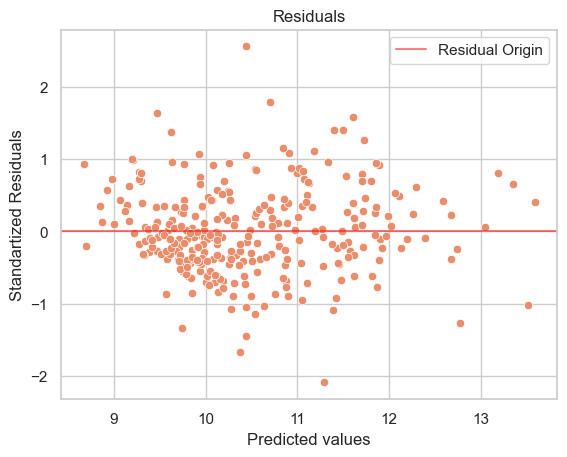

In [354]:
residual_plot(y_test, y_pred)

<h4>Conclusion</h4>
Previously it was found that Alcohol and Quality are both dependent on each other. It is clear that Alcohol linear model is also suffering from same problems as Quality model - multicollinearity and imbalance. Since Quality linear model was not successful in efficiency tuning, Alcohol model is also expected to fail and techniques like feature reduction for multilinearity removal, resampling or outlier removal will not be employed.

Alcohol linear model with 11 features show 2 times higher R^2 value than Quality model and similar values in AIC and BIC.

<h1>Visualization</h1>
https://public.tableau.com/app/profile/gintare6386/viz/Wine_quality_17040495299440/RedWineQuality?publish=yes

<h1>Conclusion</h1>

* Exploratory Data Analysis (EDA): The dataset appeared to have no missing values or outliers, and the variables showed a mix of normal and non-normal distributions.
* Correlation: No strong linear correlations were evident among the variables.
* Multicollinearity: Techniques such as variance inflation factor (VIF) analysis and feature engineering were applied to tackle multicollinearity issues.
* Statistical Testing: Hypothesis testing revealed some notable differences in mean feature values across different Quality scores.
* Models: Initially, linear regression models were created but faced challenges due to issues like multicollinearity and dataset imbalance. Attempts to improve model performance through resampling techniques and feature engineering did not yield significant enhancements.

<h2>Suggestions for Wine makers</h2>

* Pay attention to Residual Sugars and Chlorides as their values tend to cluster arround fixed values. Residual sugars contribute to the sweetness level, affecting the perceived balance and flavor. Meanwhile, chlorides, when present in excess, can impart a salty or briny taste, potentially detracting from the overall taste and diminishing the wine's quality. 
* Acidity levels go down with high levels of Alcohol (above 12 vol%).
* Balance between Sulphates and Chlorides are important. High amount of Sulphates increase levels of Chlorides in lower Alcohol lewel (above 12 vol%) red wines.

<h2>Improvement</h2>

* Explore the non-linear models: Decision Trees, Random Forests, or Gradient Boosting to improve predictive performance.
* Employing dimensionality reduction techniques like Principal Component Analysis (PCA) or t-Distributed Stochastic Neighbor Embedding (t-SNE) to condense the feature space and enhance interpretability.
* Address class imbalance by utilizing advanced methods, such as Synthetic Minority Over-sampling Technique (SMOTE), Adaptive Synthetic Sampling (ADASYN), or weighted loss functions within models.
